# MLP Example

In this notebook, we will explore how to load a custom model, specifically a Multi-Layer Perceptron (MLP), using the configuration settings defined in our project.

*Note: A bit of this notebook was inspired by [this tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html).*


## Setup


### Load Local Modules


In [1]:
from pathlib import Path
import sys
import subprocess


def get_project_root() -> Path:
    return Path(
        subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"],
            cwd=".",
            stderr=subprocess.STDOUT,
        )
        .strip()
        .decode()
    )


project_root = get_project_root()
src_dir = project_root / "src"

if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))

try:
    from utils.seed_utils import set_seed
except ImportError:
    raise ImportError("Cannot import module. Make sure that the project is on the path")

SEED = 42
set_seed(SEED)

### Setup logs and config

Here's the configuration used:

```yaml
logs:
  _target_: schemas.log_schema.LogSchema
  sink: ${path_config:run_log}
  level: INFO
  format: "{time:YYYY-MM-DD HH:mm:ss.SSS} | {level} | {thread.name} | {name}:{function}:{line} - {message}"
  rotation: 10 MB
  retention: 7 days
  colorize: true

model:
  _target_: models.smol_lm3.smol_lm3_model.SmolLM3Model
```

But we want to use an MLP model instead:

```yaml
model:
  _target_: models.mlp.mlp_model.MLPModel
```

So here we can override the model configuration when loading the settings, as shown below.


In [ ]:
from configs.app_config import AppConfig
from utils.log_utils import setup_logs


def setup(
    config_dir: str | Path | None = None,
    config_file: str = "settings.yaml",
    overrides: list[str] | None = None,
):
    AppConfig.load(
        config_dir=config_dir,
        config_file=config_file,
        overrides=overrides,
    )
    setup_logs(config=AppConfig.settings["logs"])


setup(overrides=["model._target_=models.mlp.mlp_model.MLPModel"])

## Load MLP Model


In [3]:
from utils.log_utils import log

mlp = AppConfig.settings["model"].model
log(message=mlp)

2025-10-07 18:18:48.753 | DEBUG    | __main__:<module>:4 - MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Load dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

from configs.path_config import path_config


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(
    path_config.data, train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    path_config.data, train=False, transform=transform, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)

# Class labels
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Report split sizes
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


T-shirt/top  Trouser  T-shirt/top  Coat


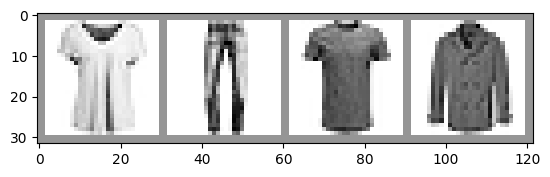

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## Setup training MLP

In [6]:
import torch
from torch import nn
from pathlib import Path

from configs.path_config import path_config
from torch.utils.tensorboard import SummaryWriter

# Hyperparameters
lr = 1e-3
epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = device.type == "cuda"
num_workers = 2 if device.type == "cuda" else 0  # safe default for notebooks

# Model
model = mlp.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)  # MLP has an internal Flatten
        loss = criterion(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)

    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc


best_val_acc = 0.0
save_dir = Path(path_config.models) / "mlp_fashionmnist"
save_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = save_dir / "checkpoint.pth"

# Setup TensorBoard
tensorboard_log_path = Path(path_config.tensorboard) / "mlp_fashionmnist"
summary_writer = SummaryWriter(log_dir=tensorboard_log_path)

## Train MLP on FashionMNIST

In [7]:
from tqdm import tqdm
from utils.tensorboard_utils import launch_tensorboard

launch_tensorboard(log_dir=tensorboard_log_path)

for epoch in tqdm(range(1, epochs + 1), desc="Training Progress"):
    train_loss, train_acc = run_epoch(model, training_loader, optimizer)
    val_loss, val_acc = run_epoch(model, validation_loader, optimizer=None)

    log(
        message=f"Epoch {epoch}/{epochs} | train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    summary_writer.add_scalars(
        main_tag="accuracy",
        tag_scalar_dict={"train": train_acc, "val": val_acc},
        global_step=epoch,
    )
    summary_writer.add_scalars(
        main_tag="loss",
        tag_scalar_dict={"train": train_loss, "val": val_loss},
        global_step=epoch,
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": {
                    **AppConfig.settings["model"].config,
                    "seed": SEED,
                },
            },
            checkpoint_path,
        )
        log(
            message=f"\tSaved new best (val_acc={best_val_acc:.4f})"
        )

/home/jmaubras/miniconda3/envs/pyenv/lib/python3.11/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Opening in existing browser session.
2025-10-07 18:19:16.756 | DEBUG    | __main__:<module>:10 - Epoch 1/5 | train_loss=0.4938 acc=0.8194 | val_loss=0.4593 acc=0.8340
2025-10-07 18:19:21.559 | DEBUG    | __main__:<module>:36 - 	Saved new best (val_acc=0.8340)


Training Progress:  20%|██        | 1/5 [00:26<01:45, 26.39s/it]

2025-10-07 18:19:43.163 | DEBUG    | __main__:<module>:10 - Epoch 2/5 | train_loss=0.3963 acc=0.8547 | val_loss=0.4200 acc=0.8500
2025-10-07 18:19:43.171 | DEBUG    | __main__:<module>:36 - 	Saved new best (val_acc=0.8500)


Training Progress:  40%|████      | 2/5 [00:48<01:10, 23.58s/it]

2025-10-07 18:20:05.909 | DEBUG    | __main__:<module>:10 - Epoch 3/5 | train_loss=0.3668 acc=0.8649 | val_loss=0.4263 acc=0.8452


Training Progress:  60%|██████    | 3/5 [01:10<00:46, 23.20s/it]

2025-10-07 18:20:27.412 | DEBUG    | __main__:<module>:10 - Epoch 4/5 | train_loss=0.3490 acc=0.8726 | val_loss=0.4304 acc=0.8489


Training Progress:  80%|████████  | 4/5 [01:32<00:22, 22.53s/it]

2025-10-07 18:20:49.170 | DEBUG    | __main__:<module>:10 - Epoch 5/5 | train_loss=0.3361 acc=0.8771 | val_loss=0.4082 acc=0.8612
2025-10-07 18:20:49.176 | DEBUG    | __main__:<module>:36 - 	Saved new best (val_acc=0.8612)


Training Progress: 100%|██████████| 5/5 [01:54<00:00, 22.80s/it]


## Predict with loaded checkpoint

In [9]:
loaded = AppConfig.settings["model"].model.to(device)
state = torch.load(checkpoint_path, map_location=device)
loaded.load_state_dict(state["model_state_dict"])

dataiter = iter(validation_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
log(message=f"Ground truth: {', '.join(classes[labels[j]] for j in range(4))}")
outputs = loaded(images)
_, preds = torch.max(outputs, 1)
log(message=f"Predicted: {', '.join(classes[preds[j]] for j in range(4))}")

2025-10-07 18:21:11.511 | DEBUG    | __main__:<module>:8 - Ground truth: Ankle Boot, Pullover, Trouser, Trouser
2025-10-07 18:21:11.513 | DEBUG    | __main__:<module>:11 - Predicted: Ankle Boot, Pullover, Trouser, Trouser


## Here, the rest of your code. Enjoy !
